In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')
plt.style.use('ggplot')

# So we don't get warnings showing up in the talk.
import warnings
warnings.filterwarnings("ignore")

![](img/climpred-logo.png)

an `xarray` wrapper for analysis of ensemble forecast models for climate prediction.

# Mission Statement

`climpred` is a high-level package that leverages the scientific python ecosystem to provide an *interactive* experience for analyzing initialized prediction systems, from file input to publication-ready visualizations.

# Why do we need a package like this?

The current convention is for scientists to write their own code snippets in their language of choice: e.g., NCL, MATLAB, GrADS, FORTRAN. This means that scientists spend a considerable portion of their research time manually aligning forecast and verification dates and writing their own metrics.

With databases like the CESM-DPLE, the Decadal Climate Prediction Protocol (DCPP), SubX, NMME, we have an unprecedented amount of prediction experiments to analyze.


If the community can unite around an open-source framework, we can spend more time analyzing output and less time writing (and re-writing) code.

# Why Python?: Open Source Capabilities

![](img/python-logo.png)

Why not NCL, MATLAB, FORTRAN?

**Python is open-source**. This makes the software transparent, and more importantly allows for community contributions and collaboration.

![](img/github-logo.png)
**Code**: <a href="https://github.com/bradyrx/climpred">
    github.com/bradyrx/climpred
</a>

**Documentation**: <a href="https://climpred.readthedocs.io/en/stable/">climpred.readthedocs.io</a>

Bugs, suggestions, discussions can be posted by any user.

![](img/github-issues.png)

New functions, metrics, etc. can be added by the community and are subject to (friendly) peer code review.

![](img/contributors.png)

Packages like `pytest` allow us to rigorously test the existing code base and any new code that is added.

![](img/pytest.png)

# Why Python?: Scientific Software

![](img/pangeo-logo.png)

The `pangeo` project organizes a community of developers working in python for Big Data geoscience research.

![](img/xarray-logo.png)

`xarray` is the core driver of `climpred` and allows for easy analysis of *labeled* multi-dimensional arrays of data.

`xarray` Datasets preserve all metadata associated with the netCDF file.

In [2]:
import xarray
dataset = xarray.tutorial.open_dataset('air_temperature')
# Convert to `cftime` for demonstration purposes.
time_cf = xarray.cftime_range('2013-01', '2015-01-01', freq='6H', calendar='gregorian')[:-1]
dataset['time'] = time_cf
# Saved to netCDF so we can demonstrate the loading functionality.
# dataset.to_netcdf('data/nmc_air_temperature.nc')

In [3]:
dataset = xarray.load_dataset('data/nmc_air_temperature.nc',
                              use_cftime=True)
print(dataset)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) object 2013-01-01 00:00:00 ... 2014-12-31 18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.49 296.19 295.69
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


In [4]:
# Get rid of attrs for easier printing later.
dataset.attrs = {}

They also intelligently handle datetime, using `cftime` to manage different model calendars (e.g. `noleap`, `gregorian`, `360_day`).

In [5]:
dataset['time'].head()

<xarray.DataArray 'time' (time: 5)>
array([cftime.DatetimeGregorian(2013-01-01 00:00:00),
       cftime.DatetimeGregorian(2013-01-01 06:00:00),
       cftime.DatetimeGregorian(2013-01-01 12:00:00),
       cftime.DatetimeGregorian(2013-01-01 18:00:00),
       cftime.DatetimeGregorian(2013-01-02 00:00:00)], dtype=object)
Coordinates:
  * time     (time) object 2013-01-01 00:00:00 ... 2013-01-02 00:00:00

Their knowledge of dimension labeling makes it easy to slice and operate over dimensions.

In [6]:
ds_slice = dataset.sel(time=slice('2013-06-05', '2013-06-06'),
                       lat=slice(50, 30),
                       lon=210)

In [7]:
print(ds_slice)

<xarray.Dataset>
Dimensions:  (lat: 9, time: 8)
Coordinates:
  * lat      (lat) float32 50.0 47.5 45.0 42.5 40.0 37.5 35.0 32.5 30.0
    lon      float32 210.0
  * time     (time) object 2013-06-05 00:00:00 ... 2013-06-06 18:00:00
Data variables:
    air      (time, lat) float32 281.5 282.79 285.19998 ... 293.69998 293.69998


In [8]:
ds_slice.std('time')

<xarray.Dataset>
Dimensions:  (lat: 9)
Coordinates:
  * lat      (lat) float32 50.0 47.5 45.0 42.5 40.0 37.5 35.0 32.5 30.0
    lon      float32 210.0
Data variables:
    air      (lat) float32 1.4029149 1.2639275 ... 0.30293193 0.39051285

Special `.groupby()` operations make it simple to compute climatologies.

In [9]:
ds_mean = dataset.mean(['lat', 'lon'])
# Group off into each point's corresponding day of the year
# and take the average over that group.
annual_cycle = ds_mean.groupby('time.dayofyear').mean('time')

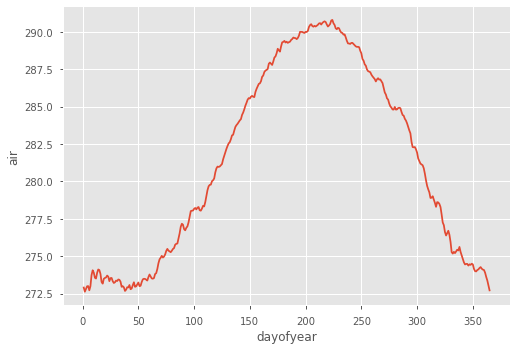

In [10]:
annual_cycle['air'].plot()

Other packages that could be covered but probably shouldn't to avoid overwhelming new python folks and in the interest of time:

* `dask` for parallel and out-of-memory computations.
* `matplotlib` for viz.
* `xskillscore` for some of our metrics.

# Top-down View of `climpred`

`climpred` expects the initialized experiment to have specific dimension labels, which can be baked into the NetCDF file or can be post-processed and renamed in python.

* `init` : Initialization dates and times. 
    - [1954, 1955, 1956, ...]
    - ['1954-01-01', '1954-01-7', ...]

* `lead` : Time since initialization.
    - [1, 2, 3, 4, ...]
    - `units` attribute: ['years', 'seasons', 'months', 'weeks', 'pentads', 'days']

* `member` : Ensemble member (optional, for probabilistic metrics).

_An arbitrary number of additional dimensions can exist. E.g.,_ `lat`, `lon`, `depth`.

## Datetime Alignment

One of the most powerful features of `climpred` is the automation of datetime alignment between the initialized prediction ensemble and the product it is being verified against.

![](img/alignment/alignment1.png)

`climpred` automatically sub-selects a set of initializations that coincide with an observed point in time and that all verify with the observational product for all lead times.

![](img/alignment/alignment3.png)

![](img/alignment/alignment4.png)

# Demo: `climpred` Input

In [11]:
import xarray

hind = xarray.open_dataset('data/DPLE.Pacific.nc')

In [12]:
print(hind)

<xarray.Dataset>
Dimensions:  (init: 64, lead: 10, nlat: 384, nlon: 320)
Coordinates:
  * init     (init) float32 1954.0 1955.0 1956.0 1957.0 ... 2015.0 2016.0 2017.0
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
    TLAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (init, lead, nlat, nlon) float32 ...


We'll be using bias-corrected SST anomaly forecasts from the CESM-DPLE over the Pacific.

In [13]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

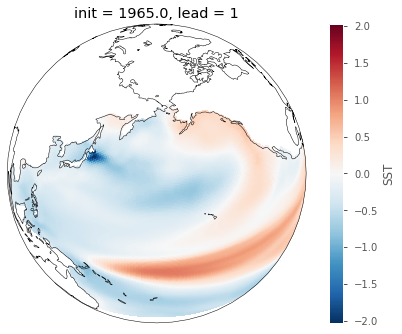

In [14]:
ax = plt.axes(projection=ccrs.Orthographic(-180, 40))

# Make use of xarray's quick plot functionality.
hind['SST'].sel(init=1965, lead=1).plot(ax=ax, transform=ccrs.PlateCarree(),
                                      x='TLONG', y='TLAT')
ax.coastlines()

`climpred` offers a `HindcastEnsemble` object that can be easily instantiated.

In [15]:
import climpred

hindcast = climpred.HindcastEnsemble(hind)
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, nlat, nlon) float32 ...
References:
    None
Uninitialized:
    None


In [16]:
fosi = xarray.open_dataset('data/FOSI.Pacific.nc')

In [17]:
# Move to anomaly space, not necessary to explain during
# presentation.
fosi = fosi - fosi.sel(time=slice(1964, 2014)).mean()

An arbitrary number of verification products can be appended to the `HindcastEnsemble` object.

In [18]:
# FOSI: Forced Ocean-Sea Ice reconstruction.
hindcast = hindcast.add_reference(fosi, name='FOSI')

# Duplicated for this demo.
hindcast = hindcast.add_reference(fosi, name='Obs2')
print(hindcast)

<climpred.HindcastEnsemble>
Initialized Ensemble:
    SST      (init, lead, nlat, nlon) float32 ...
FOSI:
    SST      (time, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
Obs2:
    SST      (time, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
Uninitialized:
    None


# Demo: `climpred` Analysis

Verification is made easy by simply running the `.compute_metric()` method and indicating one of our ~30 deterministic and probabilistic metrics.

In [19]:
acc = hindcast.compute_metric(refname='FOSI', metric='pearson_r')
print(acc)

<xarray.Dataset>
Dimensions:  (lead: 10, nlat: 384, nlon: 320)
Coordinates:
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    z_t      float32 500.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Data variables:
    SST      (lead, nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    prediction_skill:              calculated by climpred https://climpred.re...
    skill_calculated_by_function:  compute_hindcast
    number_of_initializations:     64
    metric:                        pearson_r
    comparison:                    e2r
    dim:                           time
    units:                         None
    created:                       2020-01-19 14:57

The `compute_persistence()` function allows the user to compute a reference forecast for comparison. Changing the metric requires a simple string change!

In [20]:
# Take mean over latitude and longitude.
hindcast_avg = hindcast.mean(['nlat', 'nlon'])
# Compute RMSE for forecasts relative to FOSI.
rmse = hindcast_avg.compute_metric(refname='FOSI', metric='rmse')
# Compute RMSE from persistence for FOSI.
persistence = hindcast_avg.compute_persistence(refname='FOSI', metric='rmse')

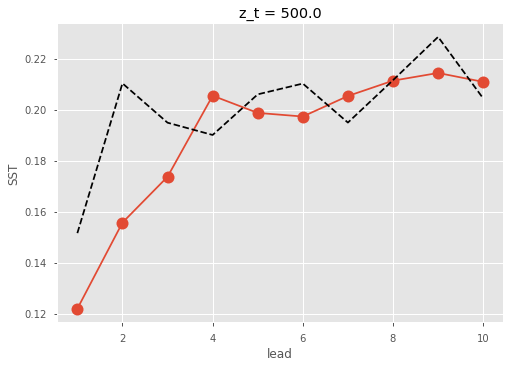

In [21]:
# Quick plotting feature of xarray.
rmse.SST.plot(marker='o', markersize=12)
persistence.SST.plot(color='k', linestyle='--')
plt.show()

Here, we use the Mean Square Skill Score.

In [22]:
# Take mean over latitude and longitude.
hindcast_avg = hindcast.mean(['nlat', 'nlon'])
# Compute Mean Square Skill Score for forecasts relative to FOSI.
msss = hindcast_avg.compute_metric(refname='FOSI', metric='msss')
# Compute Mean Square Skill Score from persistence for FOSI.
persistence = hindcast_avg.compute_persistence(refname='FOSI', metric='msss')

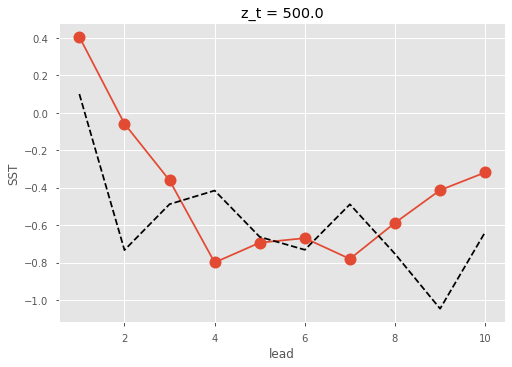

In [23]:
# Quick plotting feature of xarray.
msss.SST.plot(marker='o', markersize=12)
persistence.SST.plot(color='k', linestyle='--')
plt.show()

Users can also pass in custom metrics that aren't yet offered through `climpred` by default.

In [24]:
import numpy
def _msle(fct, obs, dim=None, **metric_kwargs):
    return ( (numpy.log(fct + 1) + numpy.log(obs + 1) ) ** 2).mean(dim)

In [25]:
from climpred.metrics import Metric
msle = Metric(
    name='msle',
    function=_msle,
    probabilistic=False,
    positive=False,
    unit_power=0,
    )

In [26]:
hindcast_avg.compute_metric(refname='FOSI', metric=msle)

<xarray.Dataset>
Dimensions:  (lead: 10)
Coordinates:
    z_t      float32 500.0
  * lead     (lead) int32 1 2 3 4 5 6 7 8 9 10
Data variables:
    SST      (lead) float32 0.078357585 0.06294025 ... 0.10350203 0.103761144
Attributes:
    prediction_skill:              calculated by climpred https://climpred.re...
    skill_calculated_by_function:  compute_hindcast
    number_of_initializations:     64
    metric:                        msle
    comparison:                    e2r
    dim:                           time
    units:                         None
    created:                       2020-01-19 14:57:34

# Advanced Visualization

Using any package from the python ecosystem, we can then produce a publication-ready figure. The main visualization package in python is `matplotlib`, but the user can use their favorite, e.g. `ggplot`, `seaborn`, ...

In [27]:
acc_map = hindcast.compute_metric(refname='FOSI', metric='pearson_r')
acc_pval = hindcast.compute_metric(refname='FOSI', metric='pearson_r_eff_p_value')

```python
import proplot as plot

plot.rc['geogrid.alpha'] = 0
plot.rc['suptitle.weight'] = 'bold'
plot.rc.fontname = 'Helvetica'

plot.rc['title.size'] = 18
plot.rc['suptitle.size'] = 18

f, axs = plot.subplots(nrows=2, ncols=5, 
                       proj='ortho',
                       proj_kw={'central_longitude': -180,
                                'central_latitude': 40},
                       top=1.5)

for i, ax in zip(range(10), axs):
    p = ax.pcolormesh(acc_map.TLONG,
                      acc_map.TLAT,
                      acc_map.SST.isel(lead=i),
                      levels=plot.arange(-1, 1, 0.1),
                      cmap='Balance')
    
    ax.contourf(acc_map.TLONG,
                acc_map.TLAT,
                acc_pval.SST.isel(lead=i),
                levels=plot.arange(0, 0.05, 0.01),
                hatches=['..'],
                alpha=0)
    
    ax.format(title=f'Lead {i+1}')

axs.format(land=True, suptitle='Potential Predictability of SSTs')
cb = f.colorbar(p, label='Anomaly Correlation Coefficient',
           loc='b', length=0.5, labelsize=18)
cb.ax.tick_params(labelsize=18) 

# f.savefig('img/example_pub_figure.png')
```

![](img/example_pub_figure.png)

# Output

If you want to visualize in your own software (e.g. NCL, GMT, ...) or save out the results of the analysis, you can easily save it out as a netCDF.

In [29]:
mape = hindcast_avg.compute_metric(refname='FOSI', metric='mape')

mape.to_netcdf('data/MAPE.SST.nc')

Now we have a NetCDF file to store away or use in any other software!

![](img/mape_command_line.png)

# `climpred` Development Roadmap

1. Add multiple reference possibilities.

```python
>>> HindcastEnsemble.compute_reference('persistence', metric='rmse')
>>> HindcastEnsemble.compute_reference('damped', metric='rmse')
>>> HindcastEnsemble.compute_reference('climatology', metric='rmse')

```

2. Robust support for S2S and diverse model calendars.
    - Currently support 'seasons', 'months', 'weeks', 'pentads', 'days' for lead time.

3. Optimize for parallel performance with `dask` in mind.

4. Polish up temporal and spatial smoothing modules.

# How To Contribute!

The number one way is to try out `climpred` and post issues/discussion topics on Github. Encourage your colleagues to try it out!

For folks with more python experience, consider opening a Pull Request. We have a detailed guide on how to add metrics and functions to the code base on the docs. We are happy to guide first time contributers as well.

Please feel free to reach out if you have any questions or advice! (riley.brady@colorado.edu)

![](img/climpred-logo.png)

Documentation: https://climpred.readthedocs.io
        
Github: https://github.com/bradyrx/climpred
        
PyPI Installation: `pip install climpred`
    
Conda Installation: `conda install -c conda-forge climpred`